# [1] Imports

We want to import all the libraries we need for the project.

In [1]:
# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.model_selection import train_test_split
from fancyimpute import IterativeImputer

# Evaluation
from sklearn.metrics import mean_squared_error

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
import xgboost as xgb

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.model_selection import train_test_split
from fancyimpute import IterativeImputer

# Evaluation
from sklearn.metrics import mean_squared_error
from nested_cv import NestedCV

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
import xgboost as xgb
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

C:\Users\caspe\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [2]:
# Set the data equal to some variables so we can use them later
train = pd.read_csv('experimental/data/train.csv')
test = pd.read_csv('experimental/data/test.csv')

# [2] Exploring the data

Here we want to explore and visualize the data, trying to explain it with graphs and find missing or NaN values.

In [3]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


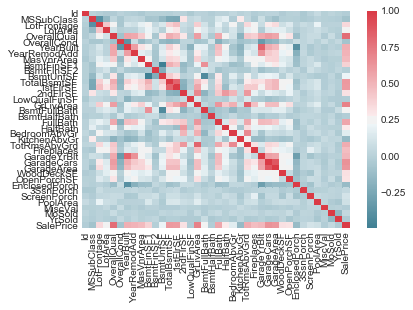

In [4]:
# Correlation plot

correlations = train.corr(method='pearson')
correlations

sns.heatmap(correlations,
            xticklabels=correlations.columns,
            yticklabels=correlations.columns,
            cmap=sns.diverging_palette(220, 10, as_cmap=True))

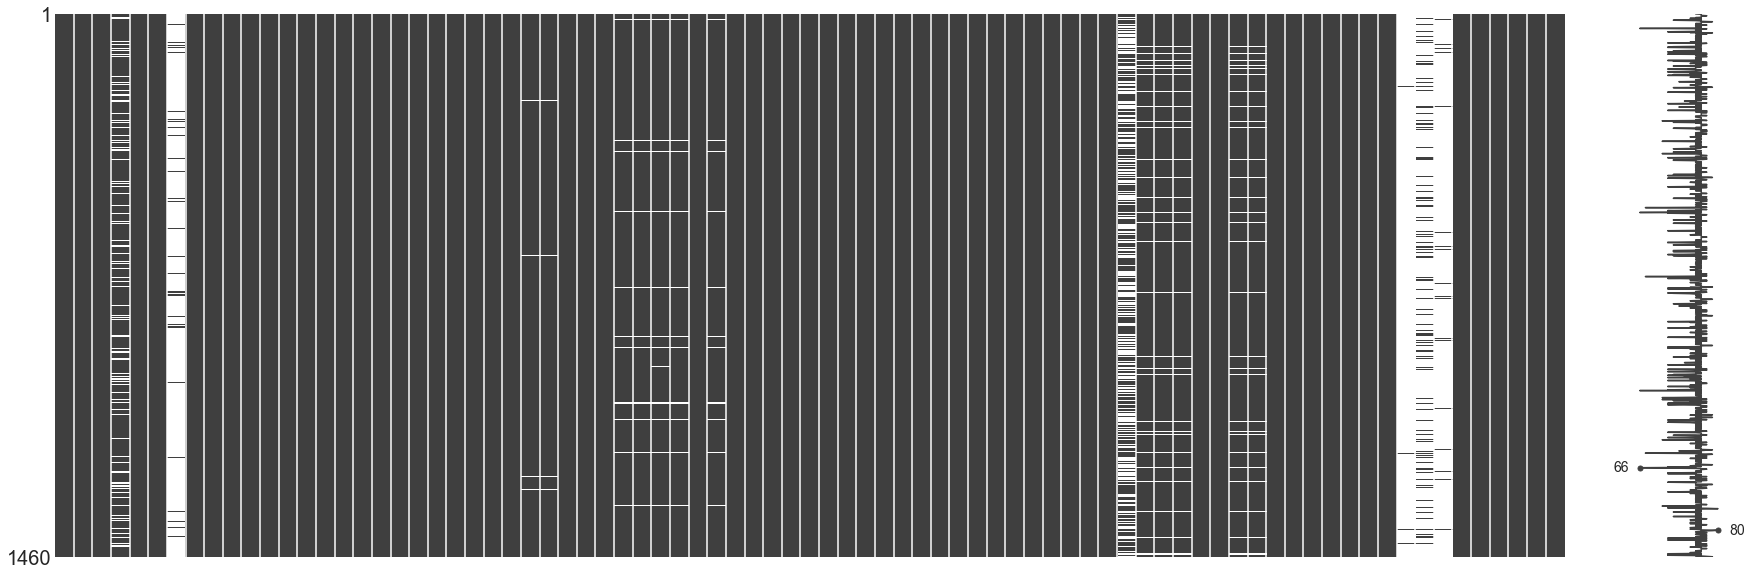

In [5]:
# Look for missing values by plotting
# Black columns are for each feature,
# And the horizontal white lines in those black columns are missing or NaN values
missingno.matrix(train, figsize = (30,10))

### Some of the columns have missing values, let's find out which ones

In [6]:
# Ok, many values are missing for some specific features
# Let's look at those
def find_missing_values(df, columns):
    """
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe
    ::param_columns:: = list of columns
    """
    missing_values = {}
    print("Number of missing or NaN values for each column:")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_values[column] = df_length - total_column_values
    return missing_values

all_missing_values_by_feature = find_missing_values(train, columns=train.columns)
all_missing_values_by_feature

Number of missing or NaN values for each column:


{'Id': 0,
 'MSSubClass': 0,
 'MSZoning': 0,
 'LotFrontage': 259,
 'LotArea': 0,
 'Street': 0,
 'Alley': 1369,
 'LotShape': 0,
 'LandContour': 0,
 'Utilities': 0,
 'LotConfig': 0,
 'LandSlope': 0,
 'Neighborhood': 0,
 'Condition1': 0,
 'Condition2': 0,
 'BldgType': 0,
 'HouseStyle': 0,
 'OverallQual': 0,
 'OverallCond': 0,
 'YearBuilt': 0,
 'YearRemodAdd': 0,
 'RoofStyle': 0,
 'RoofMatl': 0,
 'Exterior1st': 0,
 'Exterior2nd': 0,
 'MasVnrType': 8,
 'MasVnrArea': 8,
 'ExterQual': 0,
 'ExterCond': 0,
 'Foundation': 0,
 'BsmtQual': 37,
 'BsmtCond': 37,
 'BsmtExposure': 38,
 'BsmtFinType1': 37,
 'BsmtFinSF1': 0,
 'BsmtFinType2': 38,
 'BsmtFinSF2': 0,
 'BsmtUnfSF': 0,
 'TotalBsmtSF': 0,
 'Heating': 0,
 'HeatingQC': 0,
 'CentralAir': 0,
 'Electrical': 1,
 '1stFlrSF': 0,
 '2ndFlrSF': 0,
 'LowQualFinSF': 0,
 'GrLivArea': 0,
 'BsmtFullBath': 0,
 'BsmtHalfBath': 0,
 'FullBath': 0,
 'HalfBath': 0,
 'BedroomAbvGr': 0,
 'KitchenAbvGr': 0,
 'KitchenQual': 0,
 'TotRmsAbvGrd': 0,
 'Functional': 0,
 'Fir

### Ok, there is some missing values. We have to deal with that.
### We use something called FancyImpute, which implements a way of filling in Nan or missing values for us.

In [7]:
def fill_ii(df):
    # Make a dataframe of the newly calculated values from the IterativeImputer
    df_filled_ii = pd.DataFrame(IterativeImputer().fit_transform(df.values))
    
    # Assign columns and indexes as they originally were
    df_filled_ii.columns = df.columns
    df_filled_ii.index = df.index

    return df_filled_ii

# [3] Preprocessing

In [8]:
def data_engineering(train, test):
    # We have an odd number of observations. 
    train = train.drop(train.index[0])
    
    # Concatenate all of training and testing data
    # Drop columns with too many missing values
    cc_data = pd.concat([train, test], sort=True)
    cc_data = cc_data.drop(['Id', 'SalePrice','Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)
    
    # We can make the output variable logarithmic, if we want RMSLE scoring
    train["SalePrice"] = np.log1p(train["SalePrice"])
    y = train['SalePrice']
    
    # One-Hot encoding of the whole dataset
    cc_data = pd.get_dummies(cc_data, prefix_sep='_')
    
    # Fill the missing data
    cc_data = fill_ii(cc_data)
    
    # Slice our data back into training and testing data
    X_train = cc_data[:train.shape[0]]
    X_test = cc_data[train.shape[0]:]
    
    return X_train,X_test,y

### Now we run the function above, which also runs imputation, one-hot encoding and drops some features

In [9]:
X,X_test,y = data_engineering(train,test)

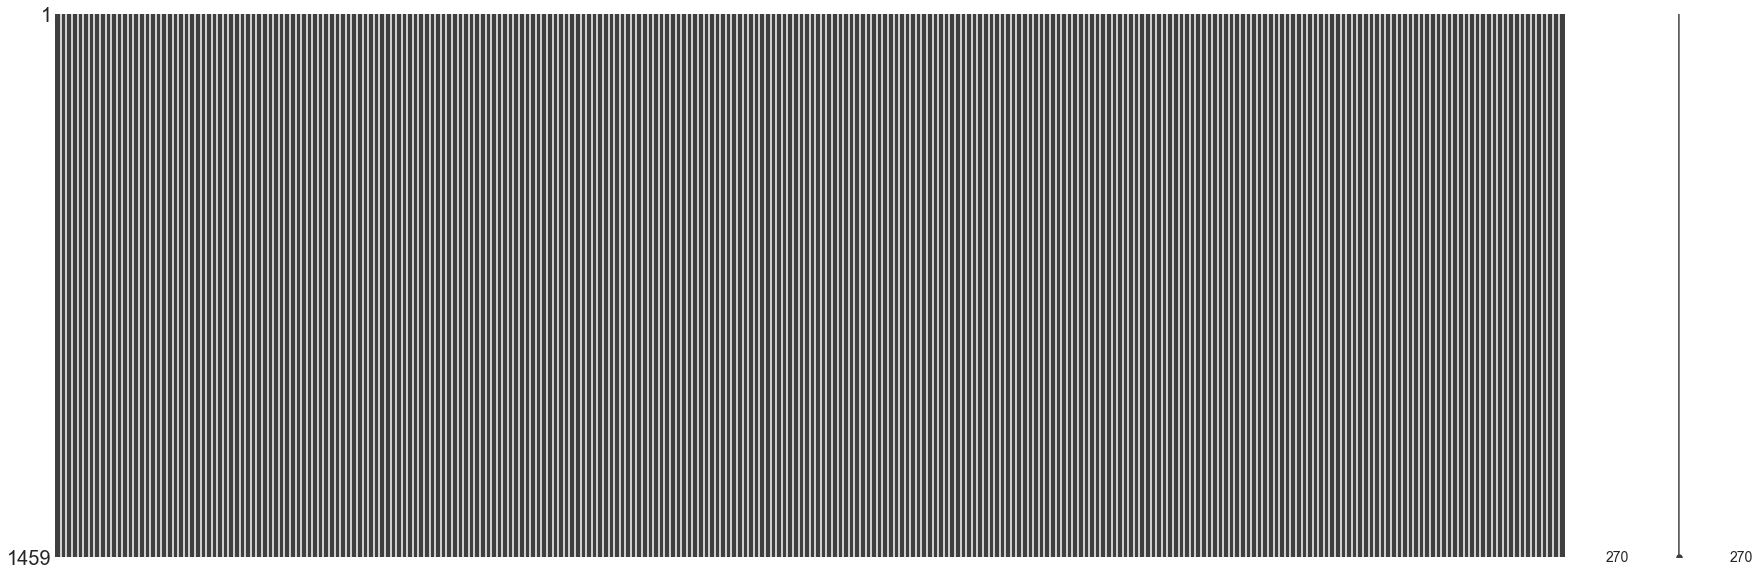

In [10]:
# Check if values have been filled
# NOTE: It has been checked, that the values are correctly filled
missingno.matrix(X, figsize = (30,10))

# [4] Modelling
The bias-variance trade-off is hard to deal with. In many instances, the predictions will be too optimistic, and therefore our scoring too low (or high). A more modern approach to getting the right tradeoff of different models is nested cross-validation.
1. Outer split: Split data into K-folds (recommended K is 5 or 10) using CV.
2. Inner split: For each of the K-folds, split the K-fold into another K-folds.
3. Search for optimal hyperparameters for some algorithm by getting the best score
4. Use optimal hyperparameters as parameters for the algorithm in each outer split

After that you look at the results and decide on the next action.

### Now we have defined the model, let's get the inputs to the model ready.
1. Define array of algorithms to run.
2. Define array of dicts with parameters. Has to be the same index as the algorithms (so they match in the nested cv function)
3. Input a dataframe X and y, the models and parameters, and specify how many K-folds each of the cross-validations split into.

There are also other parameters for the function, such as outer_metric, inner_metric and sqrt_of_score.
#### By default:
outer_metric = mean_squared_error

inner_metric = 'neg_mean_squared_error'

sqrt_of_score = False

Which means we by default evaluate by the mean squared error (MSE).

In [11]:
def create_neural_network_model(first_neuron=64,
                                activation='relu',
                                optimizer='Adam',
                                dropout_rate=0.1):
    model = Sequential()
    columns = X.shape[1]

    model.add(Dense(64, activation=activation, input_shape=(columns,)))
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(8, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))

    model.compile(
    loss='mean_squared_error',
    optimizer = 'adam',
    metrics=['mean_squared_error']
    )

    return model

In [12]:
models_to_run = [KerasRegressor(build_fn=create_neural_network_model,verbose=0),
                 RandomForestRegressor(), 
                 xgb.XGBRegressor()]

models_param_grid = [
    { # 1st param grid, corresponding to KerasRegressor
        'epochs' : [50,100,150,200],
        'batch_size' : [16,32],
        'optimizer' : ['Adam', 'Nadam', 'Adamax'],
        'dropout_rate' : [0.1, 0.3, 0.5],
        'activation' : ['relu', 'elu'],
        'first_neuron' : [64, 128, 256]
    },
    { # 2nd param grid, corresponding to RandomForestRegressor
        'max_depth': [3, None],
        'n_estimators': [100,200,300,400,500,600,700,800,900,1000],
        'max_features' : [50,100,150,200]
    },
    { # 3rd param grid, corresponding to XGBRegressor
        'learning_rate': [0.05],
        'colsample_bytree': np.linspace(0.3, 0.5),
        'n_estimators': [100,200,300,400,500,600,700,800,900,1000],
        'reg_alpha' : (1,1.2),
        'reg_lambda' : (1,1.2,1.4)
    }
]

In [14]:
NUM_TRIALS = 1 #50 (we ran it 50 times)

RF_scores = []
XGB_scores = []
NN_scores = []

for trial in range(NUM_TRIALS):
    print('TRIAL NUMBER: ', trial+1)
    for i,model in enumerate(models_to_run):
        nested_CV_search = NestedCV(model=model, params_grid=models_param_grid[i], outer_kfolds=5, 
                                    inner_kfolds=5, cv_options={'sqrt_of_score':True,'randomized_search_iter':30})
        nested_CV_search.fit(X=X,y=y)
        model_param_grid = nested_CV_search.best_params
        print('\nCumulated best parameter grids was:\n{0}'.format(model_param_grid))

        gscv = GridSearchCV(estimator=model, param_grid=model_param_grid, scoring='neg_mean_squared_error', cv=5)
        gscv.fit(X,y)

        print('\nFitting with optimal parameters:\n{0}'.format(gscv.best_params_))

        gscv.predict(X_test)
        score = np.sqrt(-gscv.best_score_)

        if(type(model).__name__ == 'KerasRegressor'):
            NN_scores.append(score)
        elif(type(model).__name__ == 'RandomForestRegressor'):
            RF_scores.append(score)
        elif(type(model).__name__ == 'XGBRegressor'):
            XGB_scores.append(score)

        print('\nFinal score for {0} was {1}'.format(type(model).__name__,score))

TRIAL NUMBER:  1

KerasRegressor <-- Running this model now

RandomForestRegressor <-- Running this model now

XGBRegressor <-- Running this model now


In [15]:
print(RF_scores)
print(XGB_scores)
print(NN_scores)

[]
[]
[]
